<center><font size=5>Milestone Project -- Private Trainers Consulting Report

# Introduction of dataset and client
Our clinet SportStat is partnering with private trainers and has decided to open an Olympic training club in coming years and aim to perform well in forthcoming Olympics. This report employed the dataset of all Olympics events over the past 120 years, and is aimed to provide a holistic view of past performance of each country/sport/athletes and offer some macroscopic advise to future private trainers about:
1. WHERE to open their training clubs?
2. WHAT sport should they choose?
3. WHO should they choose? (What are the physical characterics of the athletes they should consider?)


This project will explore the performance and characteristics of each country and athletes in the Olympics for the past 120 years, including the trend of number of gold medals won by top performing countries, and some personal traits of athletes such as differences in preferences and specialization between male and female athletes, as well as the physical features of athletes participating in each sport.



# Importation and data cleaning
Below are the importing and cleaning process of the dataset.

In [291]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.dates as mdate
import datetime
import time
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from dateutil.parser import parse
from collections import OrderedDict

In [342]:
regions=pd.read_csv('noc_regions.csv')
events=pd.read_csv('athlete_events.csv')

In [4]:
#cleaning, fill height and weight with average
avr_h = events.groupby('Sex')['Height'].mean()
events.Height=events.apply(lambda x: avr_h[x.Sex] if pd.isnull(x.Height) else x.Height,axis=1)

In [5]:
avr_w = events.groupby('Sex')['Weight'].mean()
events.Weight=events.apply(lambda x: avr_w[x.Sex] if pd.isnull(x.Weight) else x.Weight,axis=1)

In [19]:
pd.set_option('display.float_format',lambda x: '%.2f' % x)
events.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.00,180.00,80.00,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.00,170.00,60.00,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.00,178.86,75.74,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.00,178.86,75.74,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.00,185.00,82.00,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


# Questions, hypothesis and approach
## Questions
Based on the advisory questions listed in the introduction section, 4 specific criterias will be analyzed in detail:
1. What are the trends for the number of gold medals in the past 120 years in best performing countries?
2. What are the top performing sports in each of these best performing countries?
3. What are the differences of the preferences and specializations of the sports participated by athletes of different gender?
4. What are the average BMIs (Body Mass Index) for each sports?

## Hypotheses
Here are some hypotheses corresponding to the 4 criterias:
1. There is an increasing trend of the number of gold medals in best performing countries, since I believe best performing countries tend to have better resources and skills, so their performance will keep improving.
2. There will be similarities between top performing sports in each of the top performing country.
3. Female athletes tend to participate in sports that require more flexibility  than male athletes, such as gymnastics. Male athletes tend to participate in sports that are more competitive such as basketballs.
4.  The average BMI of a sport is related to the skillset required by this sport. 

## Approach
Here are the approach that will be taken to answer each question:
1. First define best performing countries by assigning different weights to different medals and summing the number of medals in each country for past 10 years and rank them. Then the first 3 countries will be the best performing countries. Finally their trend will be analyzed by plotting a time series plot.
2. For each top performing countries, their total medals for each sport will be calculated and ranked, and the top 10 sports will be shown in bar chart.
3. Calculate the proportion of athletes of each sex that participated in 20 most commonly participated sport, then compare the two to see the difference in distributions of sports participated by male and female athletes.
4. Calculate the BMI for each athletes, and average them according to sport.

# Metrics used
1. Medal points: A key metric used to meaure a country/atheletes' performance. Each medal will be assigned a different weight: 4 for Gold, 2 for Silver and 1 for Bronze. This is to standardize the performance, by weighing more to high level achievement and less to lower level achivement, to calculate the performance in a fairer way.
2. BMI: Body Mass Index. This is a standardized metric used to measure the body shape/fit of an athlete. Calculated as Weight(kg)/Height(m)^2.

# Results and discussions
## Q1: The trend for the number of gold medals in the past 120 years in best performing countries

In [410]:
#converting medal to points and calculate each country's total points every year, and average points of 120 years.
events['points'] = events['Medal']
events['points'] = events['points'].replace('Gold',4)
events['points'] = events['points'].replace('Silver',2)
events['points'] = events['points'].replace('Bronze',1)

points = events.groupby(['Team','Year'])['points'].sum().reset_index().sort_values(by=['Team','points'],ascending=[1,0])
avr = points.groupby('Team')['points'].mean().sort_values(ascending=False).reset_index()
sd = points.groupby('Team')['points'].std().sort_values(ascending=False).reset_index()
points_a = pd.merge(points,avr,how='left',on='Team')
points_as = pd.merge(points_a,sd,how='left',on='Team')
points_as.columns=['Team','Year','points','avr','sd']
points_as['standard'] = (points_as['points']-points_as['avr'])/points_as['sd']

The top three countries which won the most medal points in recent 10 years are United States, Russia and Canada.

In [411]:
# Top countries
ymax = events['Year']<=2020
ymin = events['Year']>=2010
golddf = events[gold]
golddf_recent = events[gold&ymax&ymin]
golddf_recent.groupby('Team')['points'].sum().sort_values(ascending=False).reset_index()[:3]

,Team,points
0,United States,1168.00
1,Russia,524.00
2,Canada,500.00


In [429]:
#time series of medal points
def ts(country=''):
    c = golddf['Team'] == country
    ts = golddf[c].groupby('Year')['Medal'].count().reset_index()
    golddf1 = ts[['Year','Medal']]
    golddf1.columns = ['Year','Number of Gold Medals']
    plt.figure(figsize=(30,8),dpi=150)
    sns.lineplot(golddf1['Year'],golddf1['Number of Gold Medals'])
    plt.rcParams['figure.dpi'] = 150
    plt.title('Number of Gold Medals in'+' '+country,fontsize=20)
    plt.xlim(1900,2020)

Below are the time series of United States, Russia and Canada for the medal points won in past 120 years.

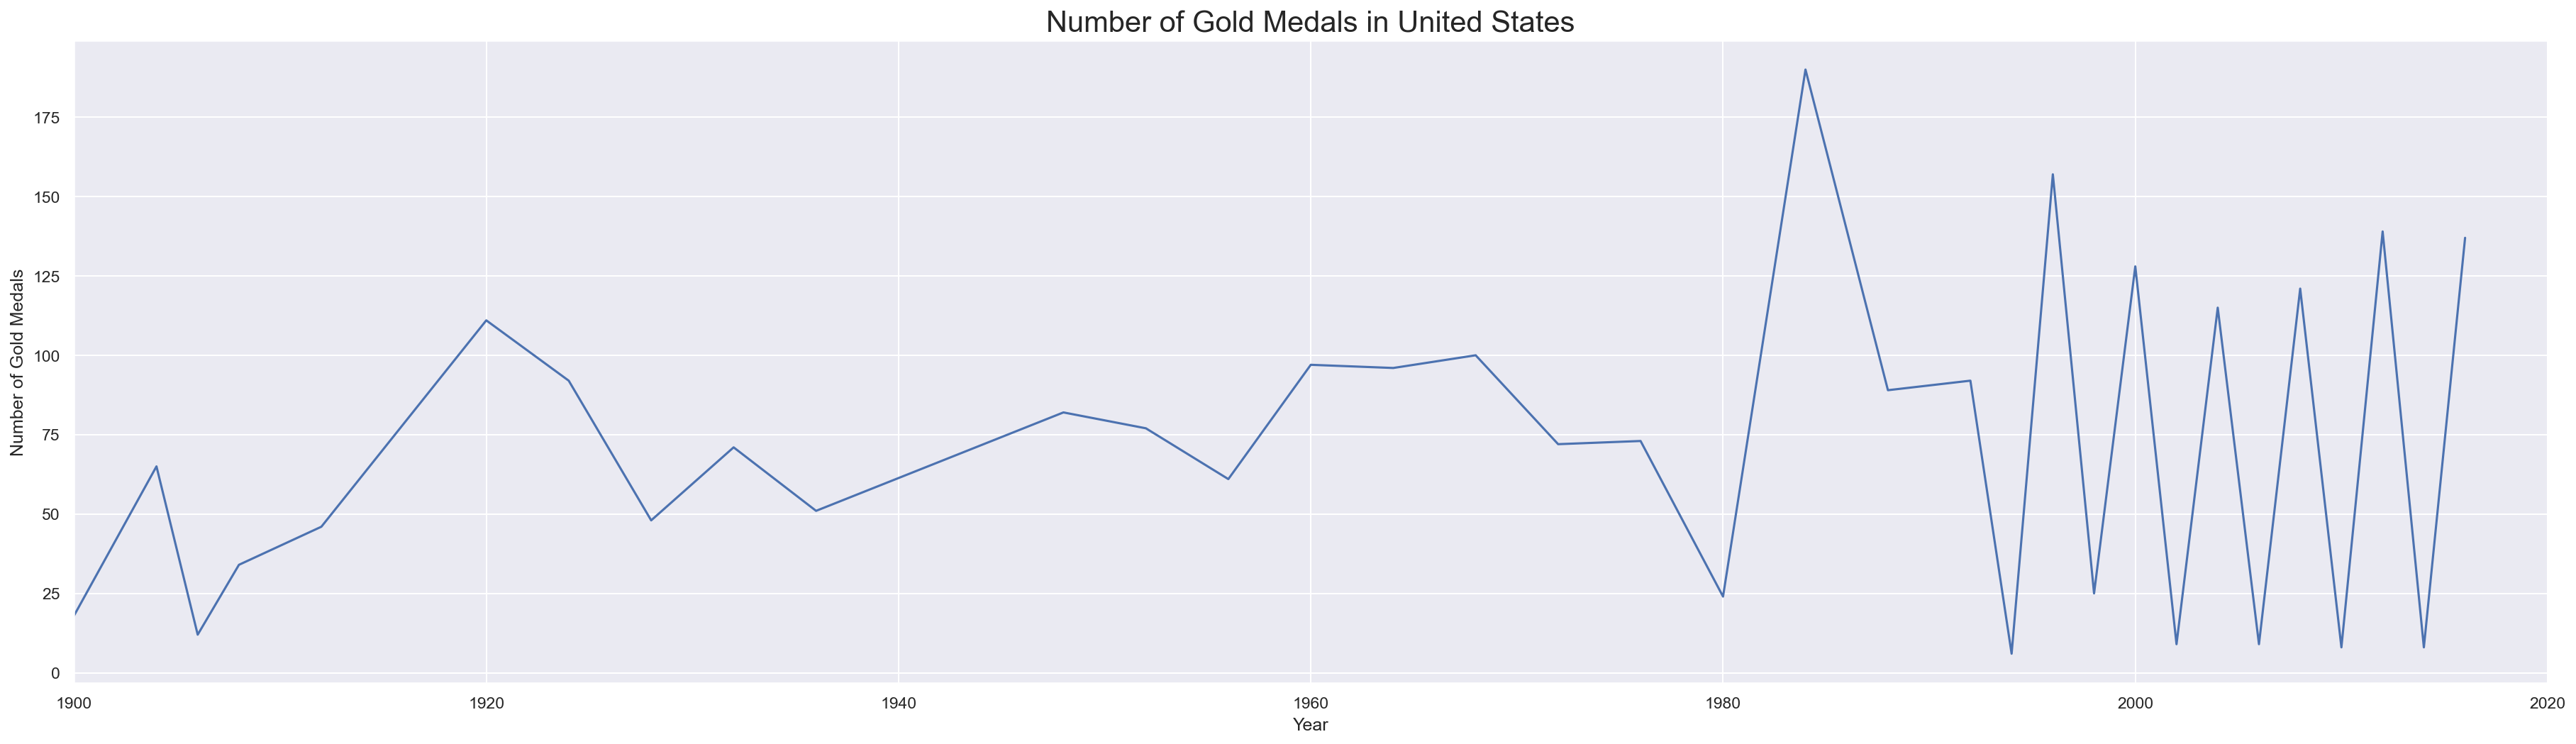

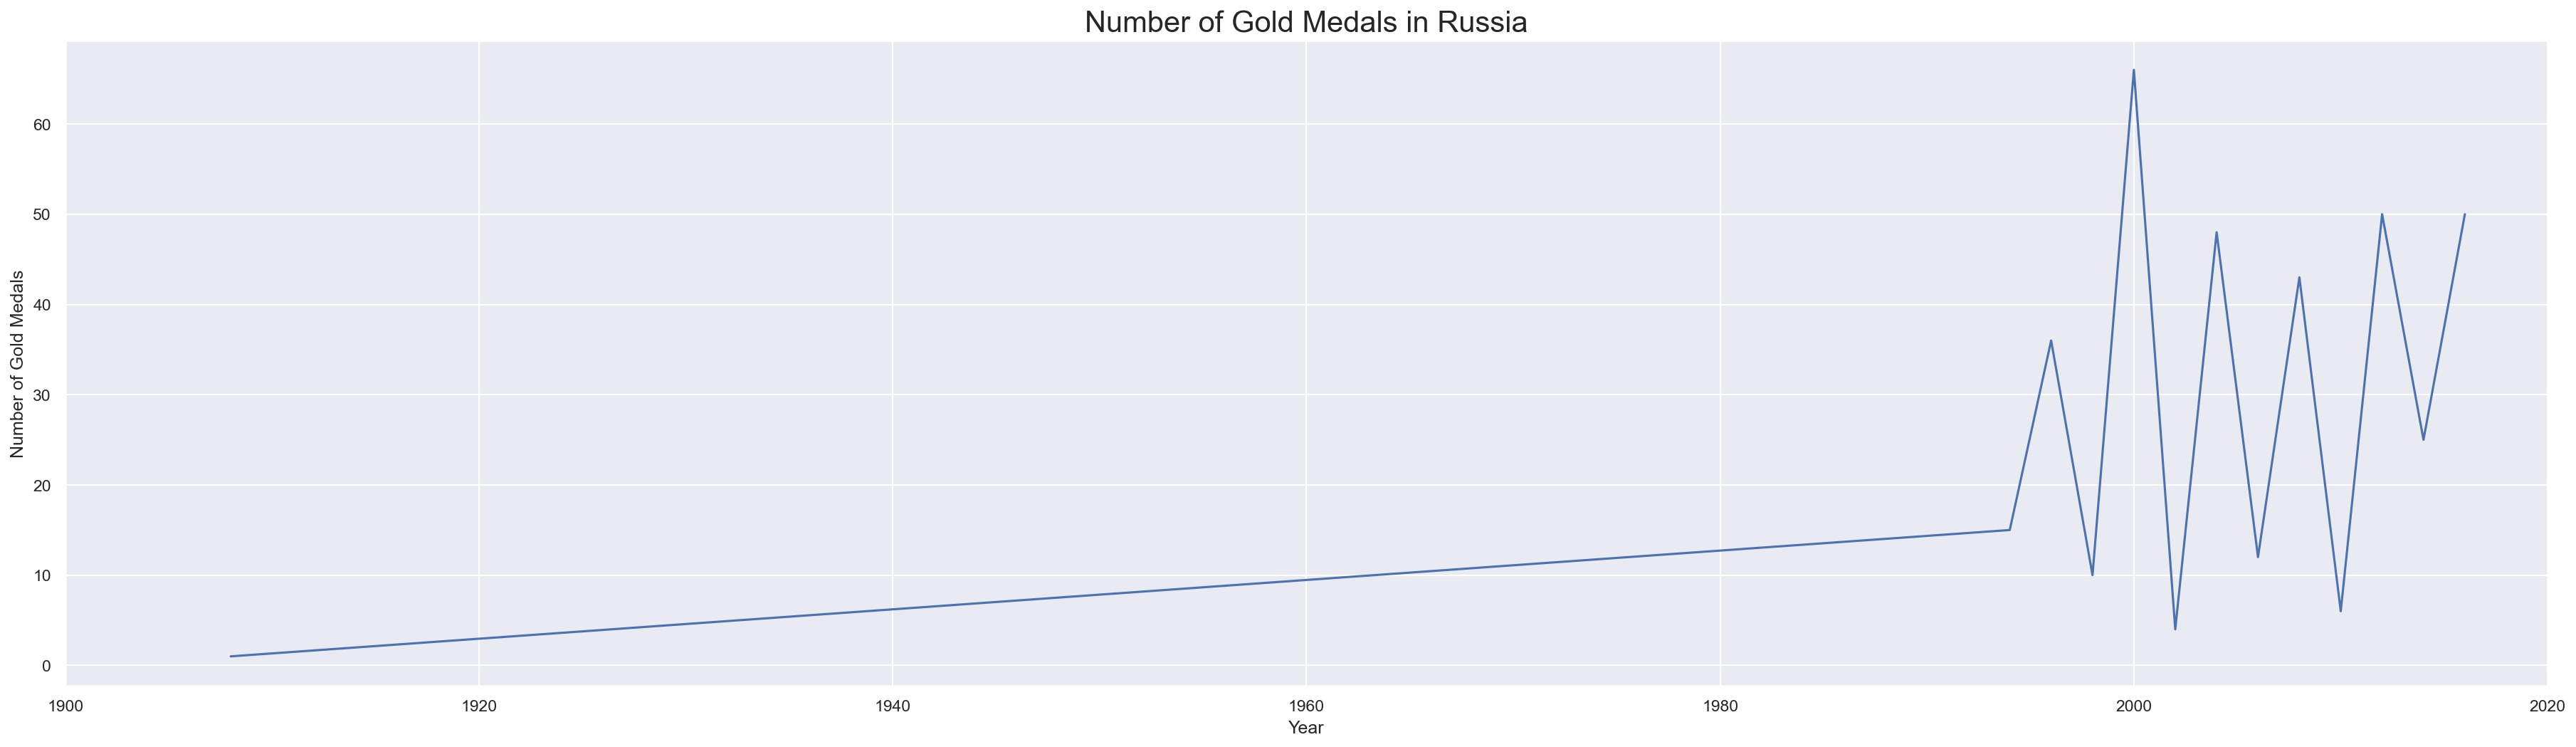

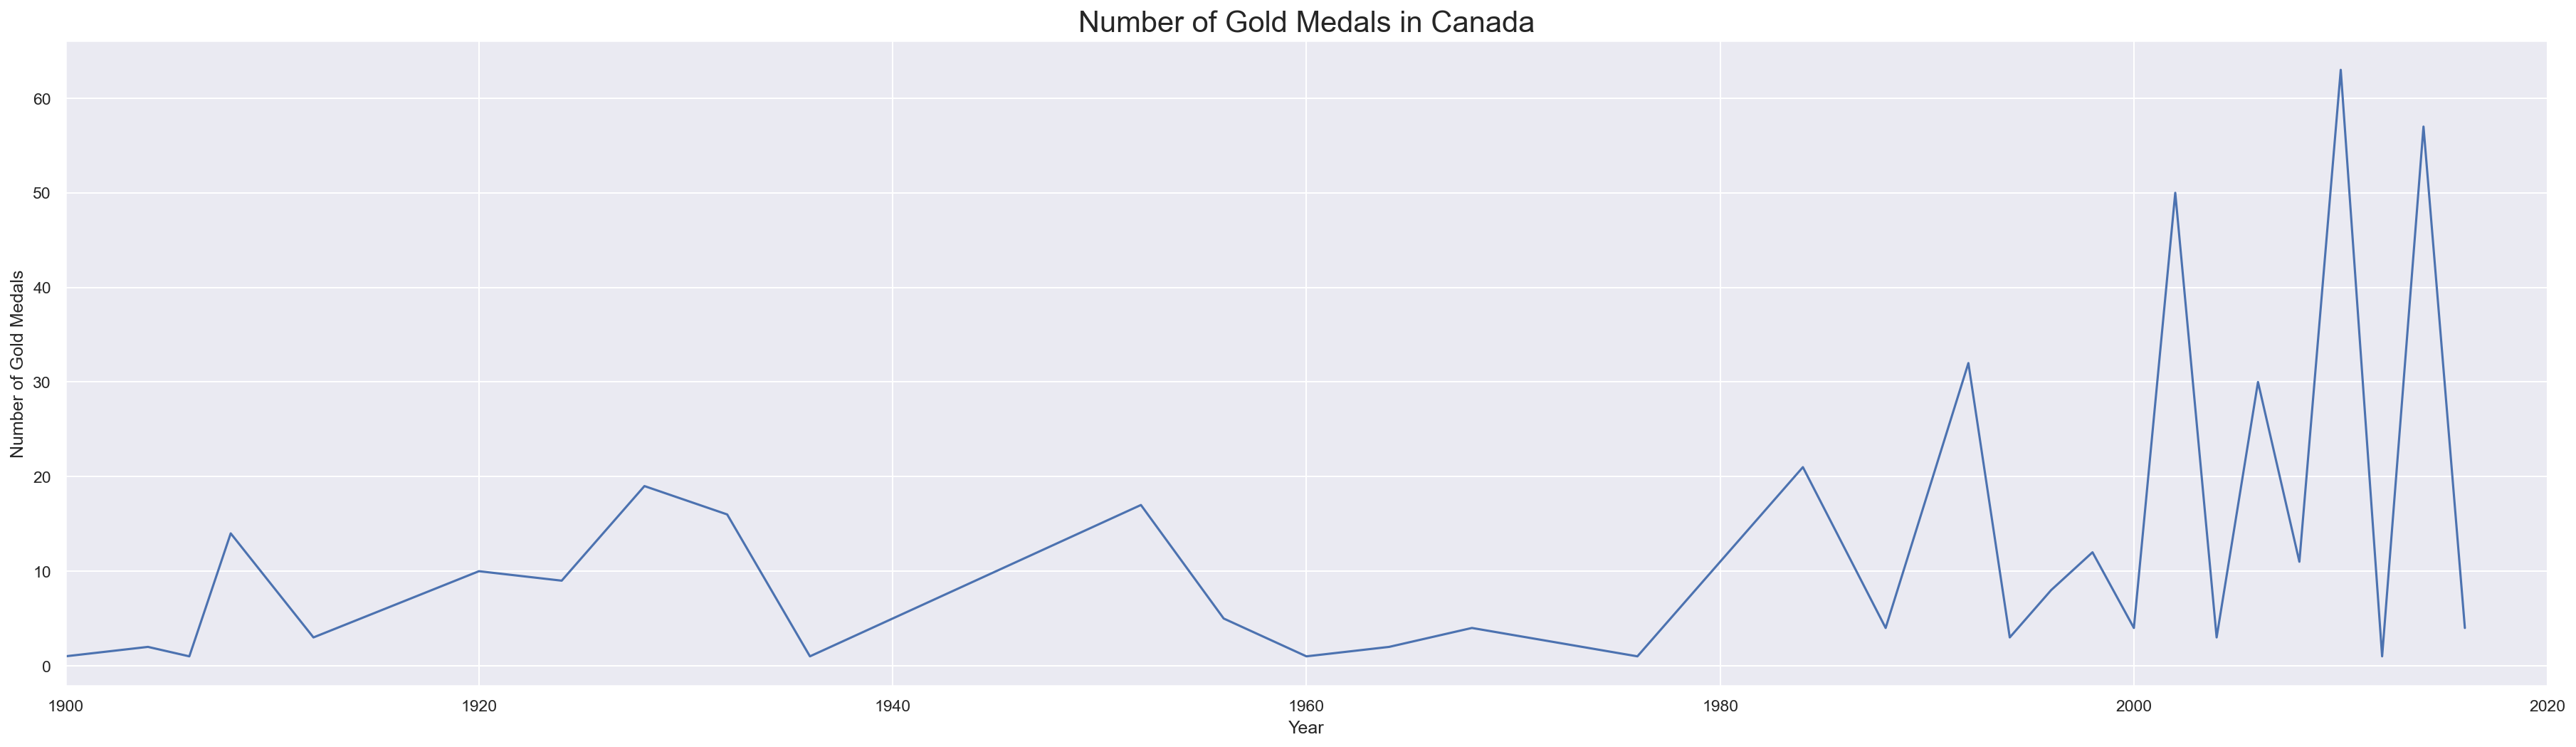

In [430]:
top_ctry = ['United States','Russia','Canada']
for country in top_ctry: 
    ts(country)

From the time seires graph it can be seen that there is a similar parttern of the medal points won by United States, Russia and Canada over the past 120 years: they are all relatively smooth in more distant years, and start to fluctuate in recent years (after 1990). 

In terms of trends: Before 1990, there is a slight increasing trend in United States and Russia, and a steady performance in Canada. After 1990, all three countries' performance tend to fluctuate to a great extent and exhibit no observable trend. Therefore hypothesis 1 is not proved to be true.

In terms of co-movements: It is also observable that there are co-movements between the three countries in recent years. In particular, United states and Russia's performance tend to have a positive relationship, that is, the medal points won by these two countries tend to increase and decrease in similar pace. On the other hand, United States' performance tend to have a negative relationship between Canada, it can be seen from the graph that peaks in United States corresponds to troughs in Canada. 

In terms of autocorrelations: There seems to be a negative autocorrelation in the three countries, which means that a year of outstanding performance will lead to a relative poor performance in the next year.

All these results imply that there is increasing competitiveness in Olympics in recent years, such that countries' performance is not steady and there is no observable improvements. Furthermore, United States and Canada may be the main rivalries of each other, since their performance is negatively correlated.

## Q2: Top performing sports in top performing countries

In [424]:
def top_sports_ctry(country=''):
    c = events['Team'] == country
    top10 = events[c].groupby(['Sport'])['points'].sum().sort_values(ascending=False).reset_index()[:10]
    plt.figure(figsize=(20,8),dpi=150)
    sns.barplot(top10['Sport'],top10['points'])
    plt.xticks(rotation=60,fontsize=20)
    for x,y in enumerate(top10['points']):
        plt.text(x,y,'%s' %round(y),ha='center',va='bottom')
    plt.title('Top 10 Sports in ' + country,fontsize=20)
    return plt.show()

Below are the bar charts of the top 10 performing sports over past 120 years in United States, Russia and Cancada.

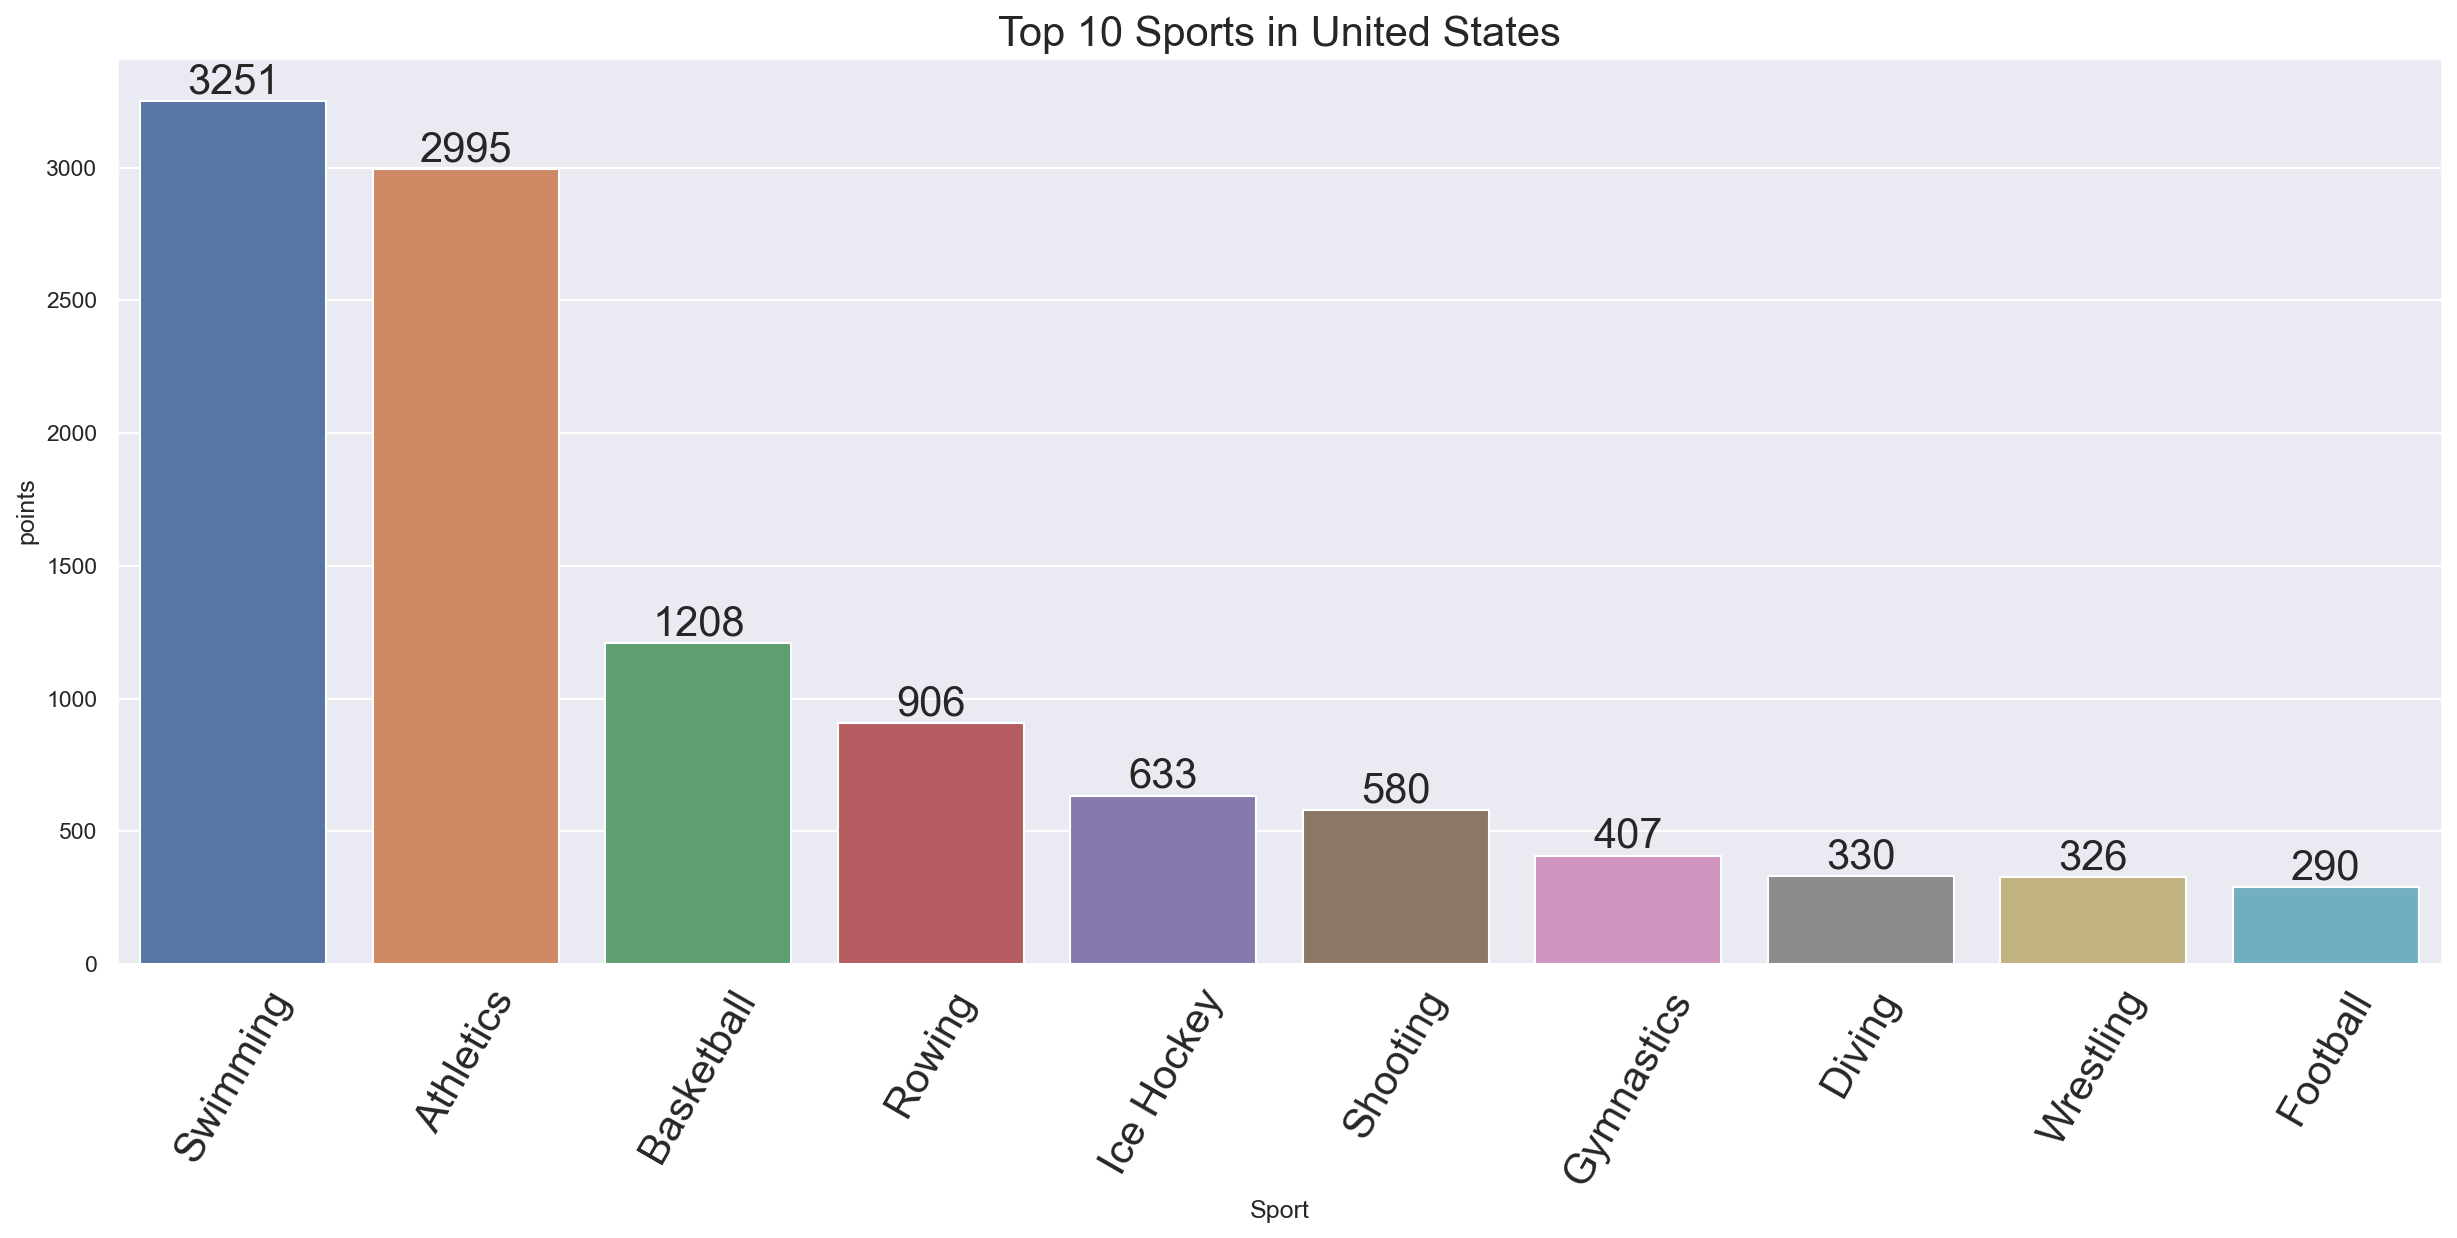

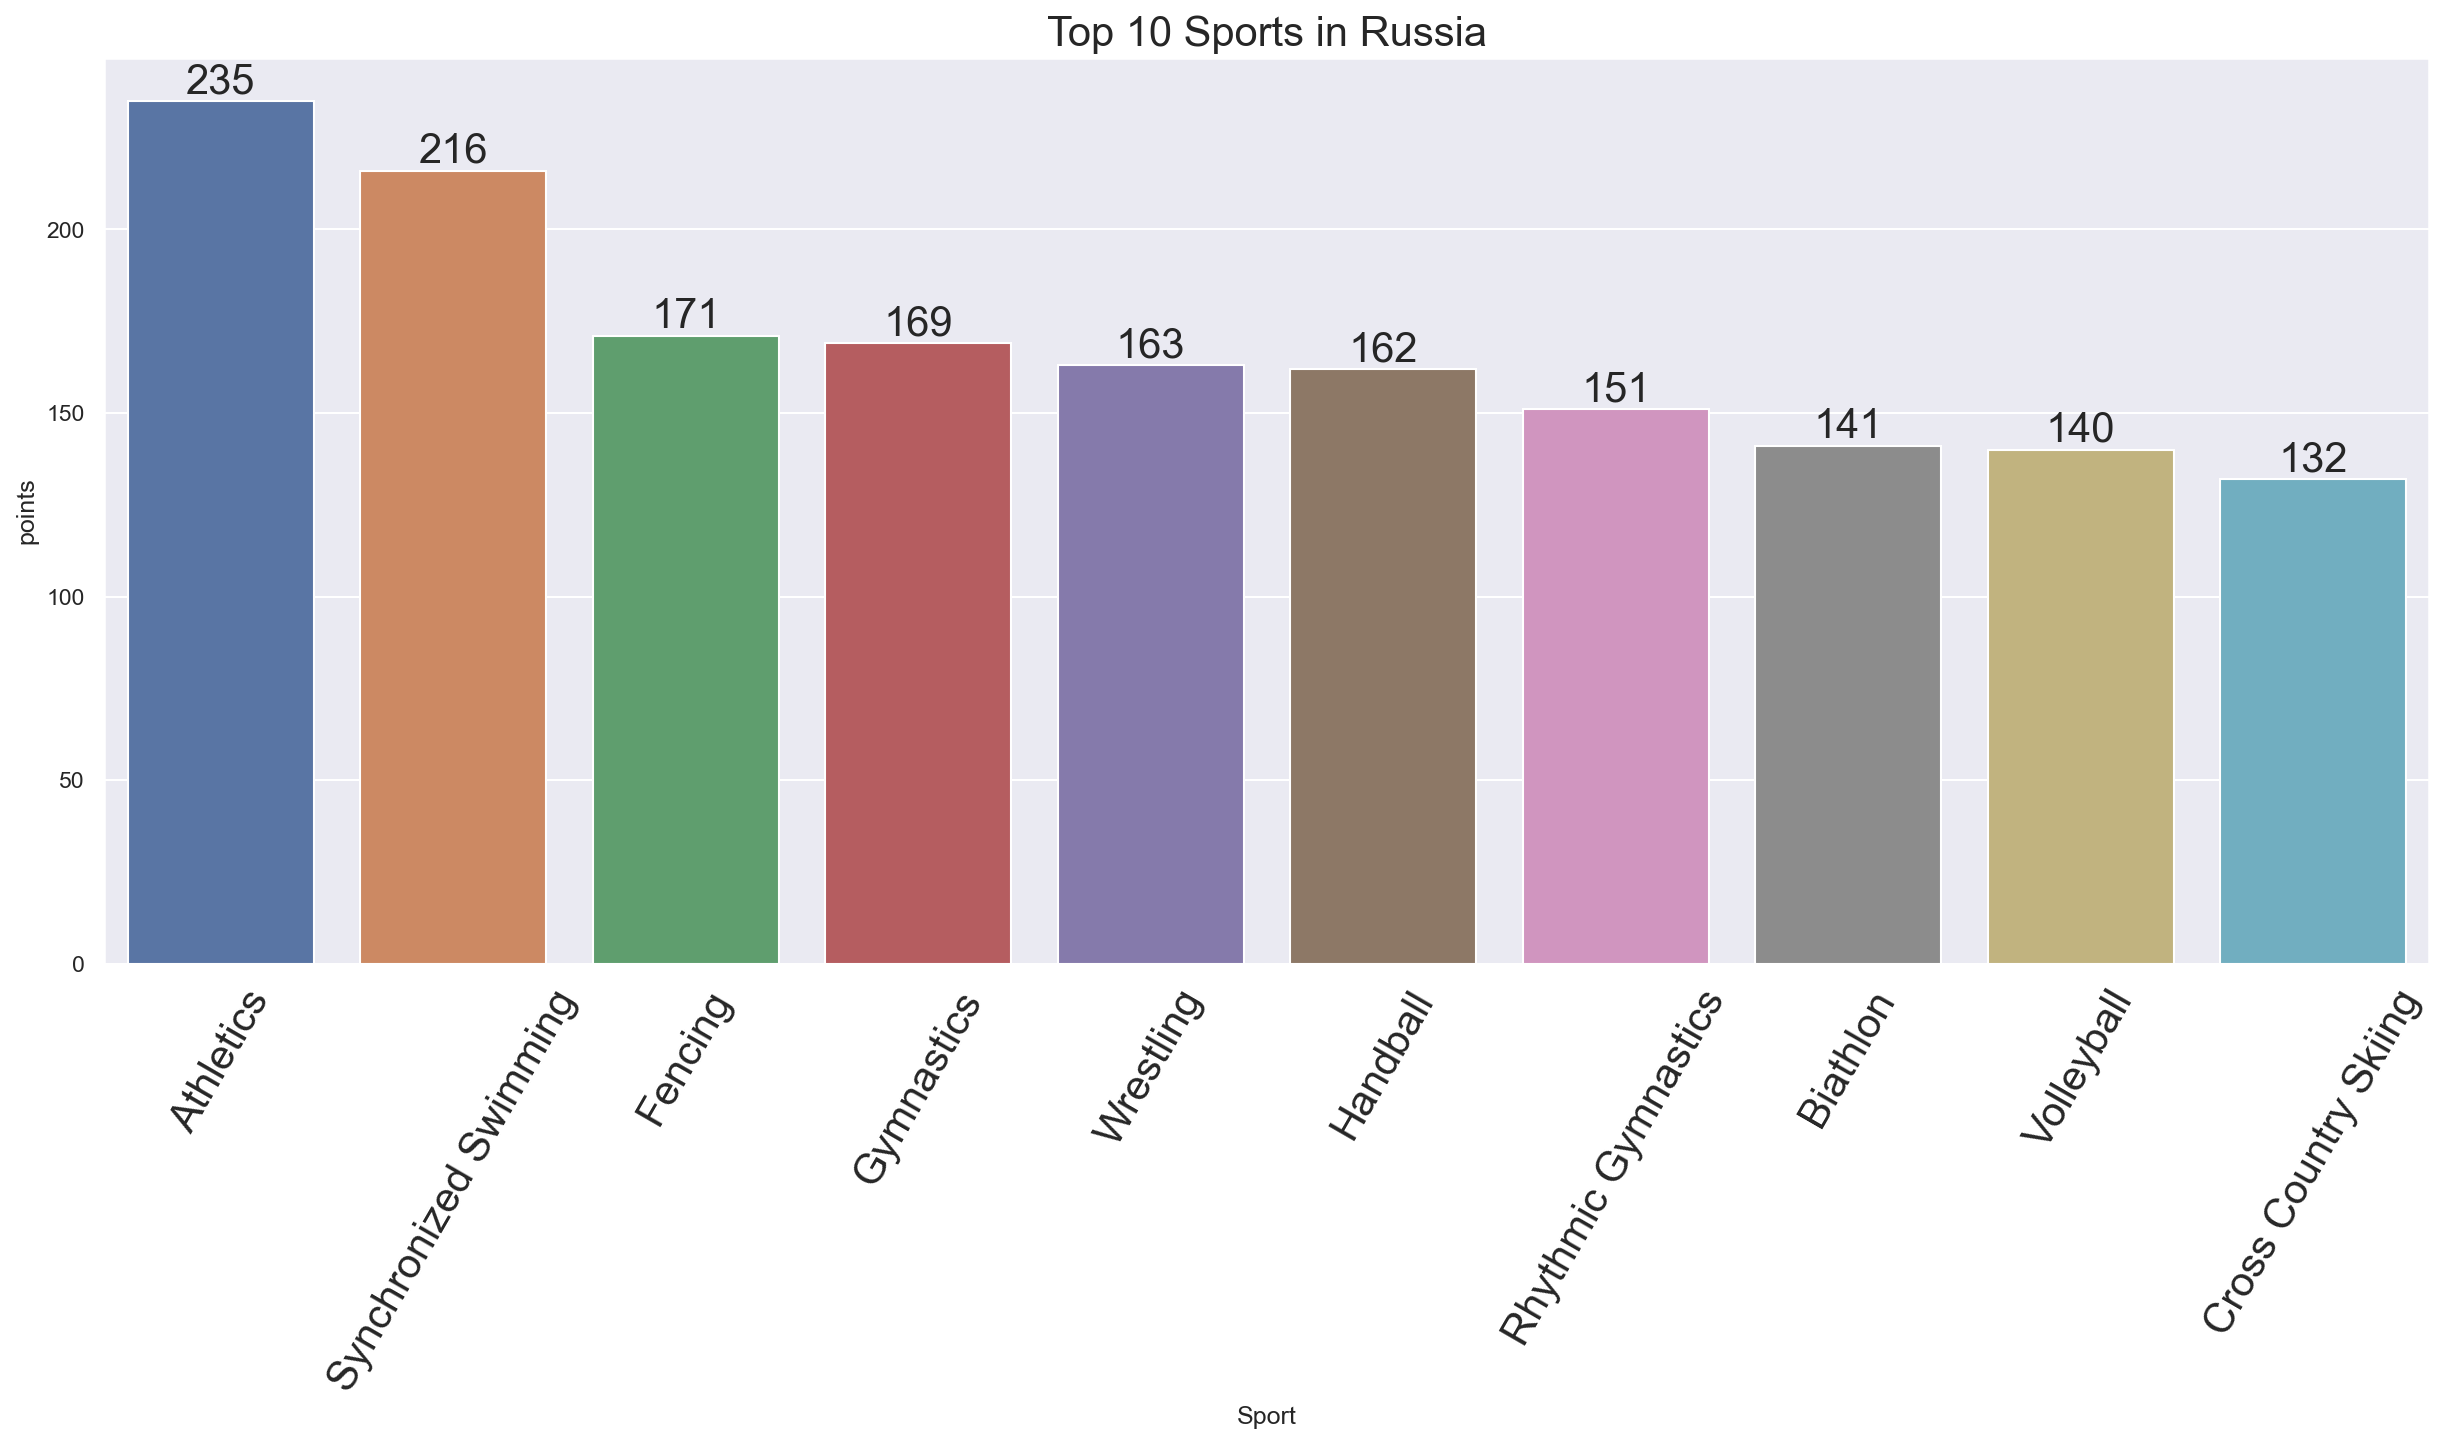

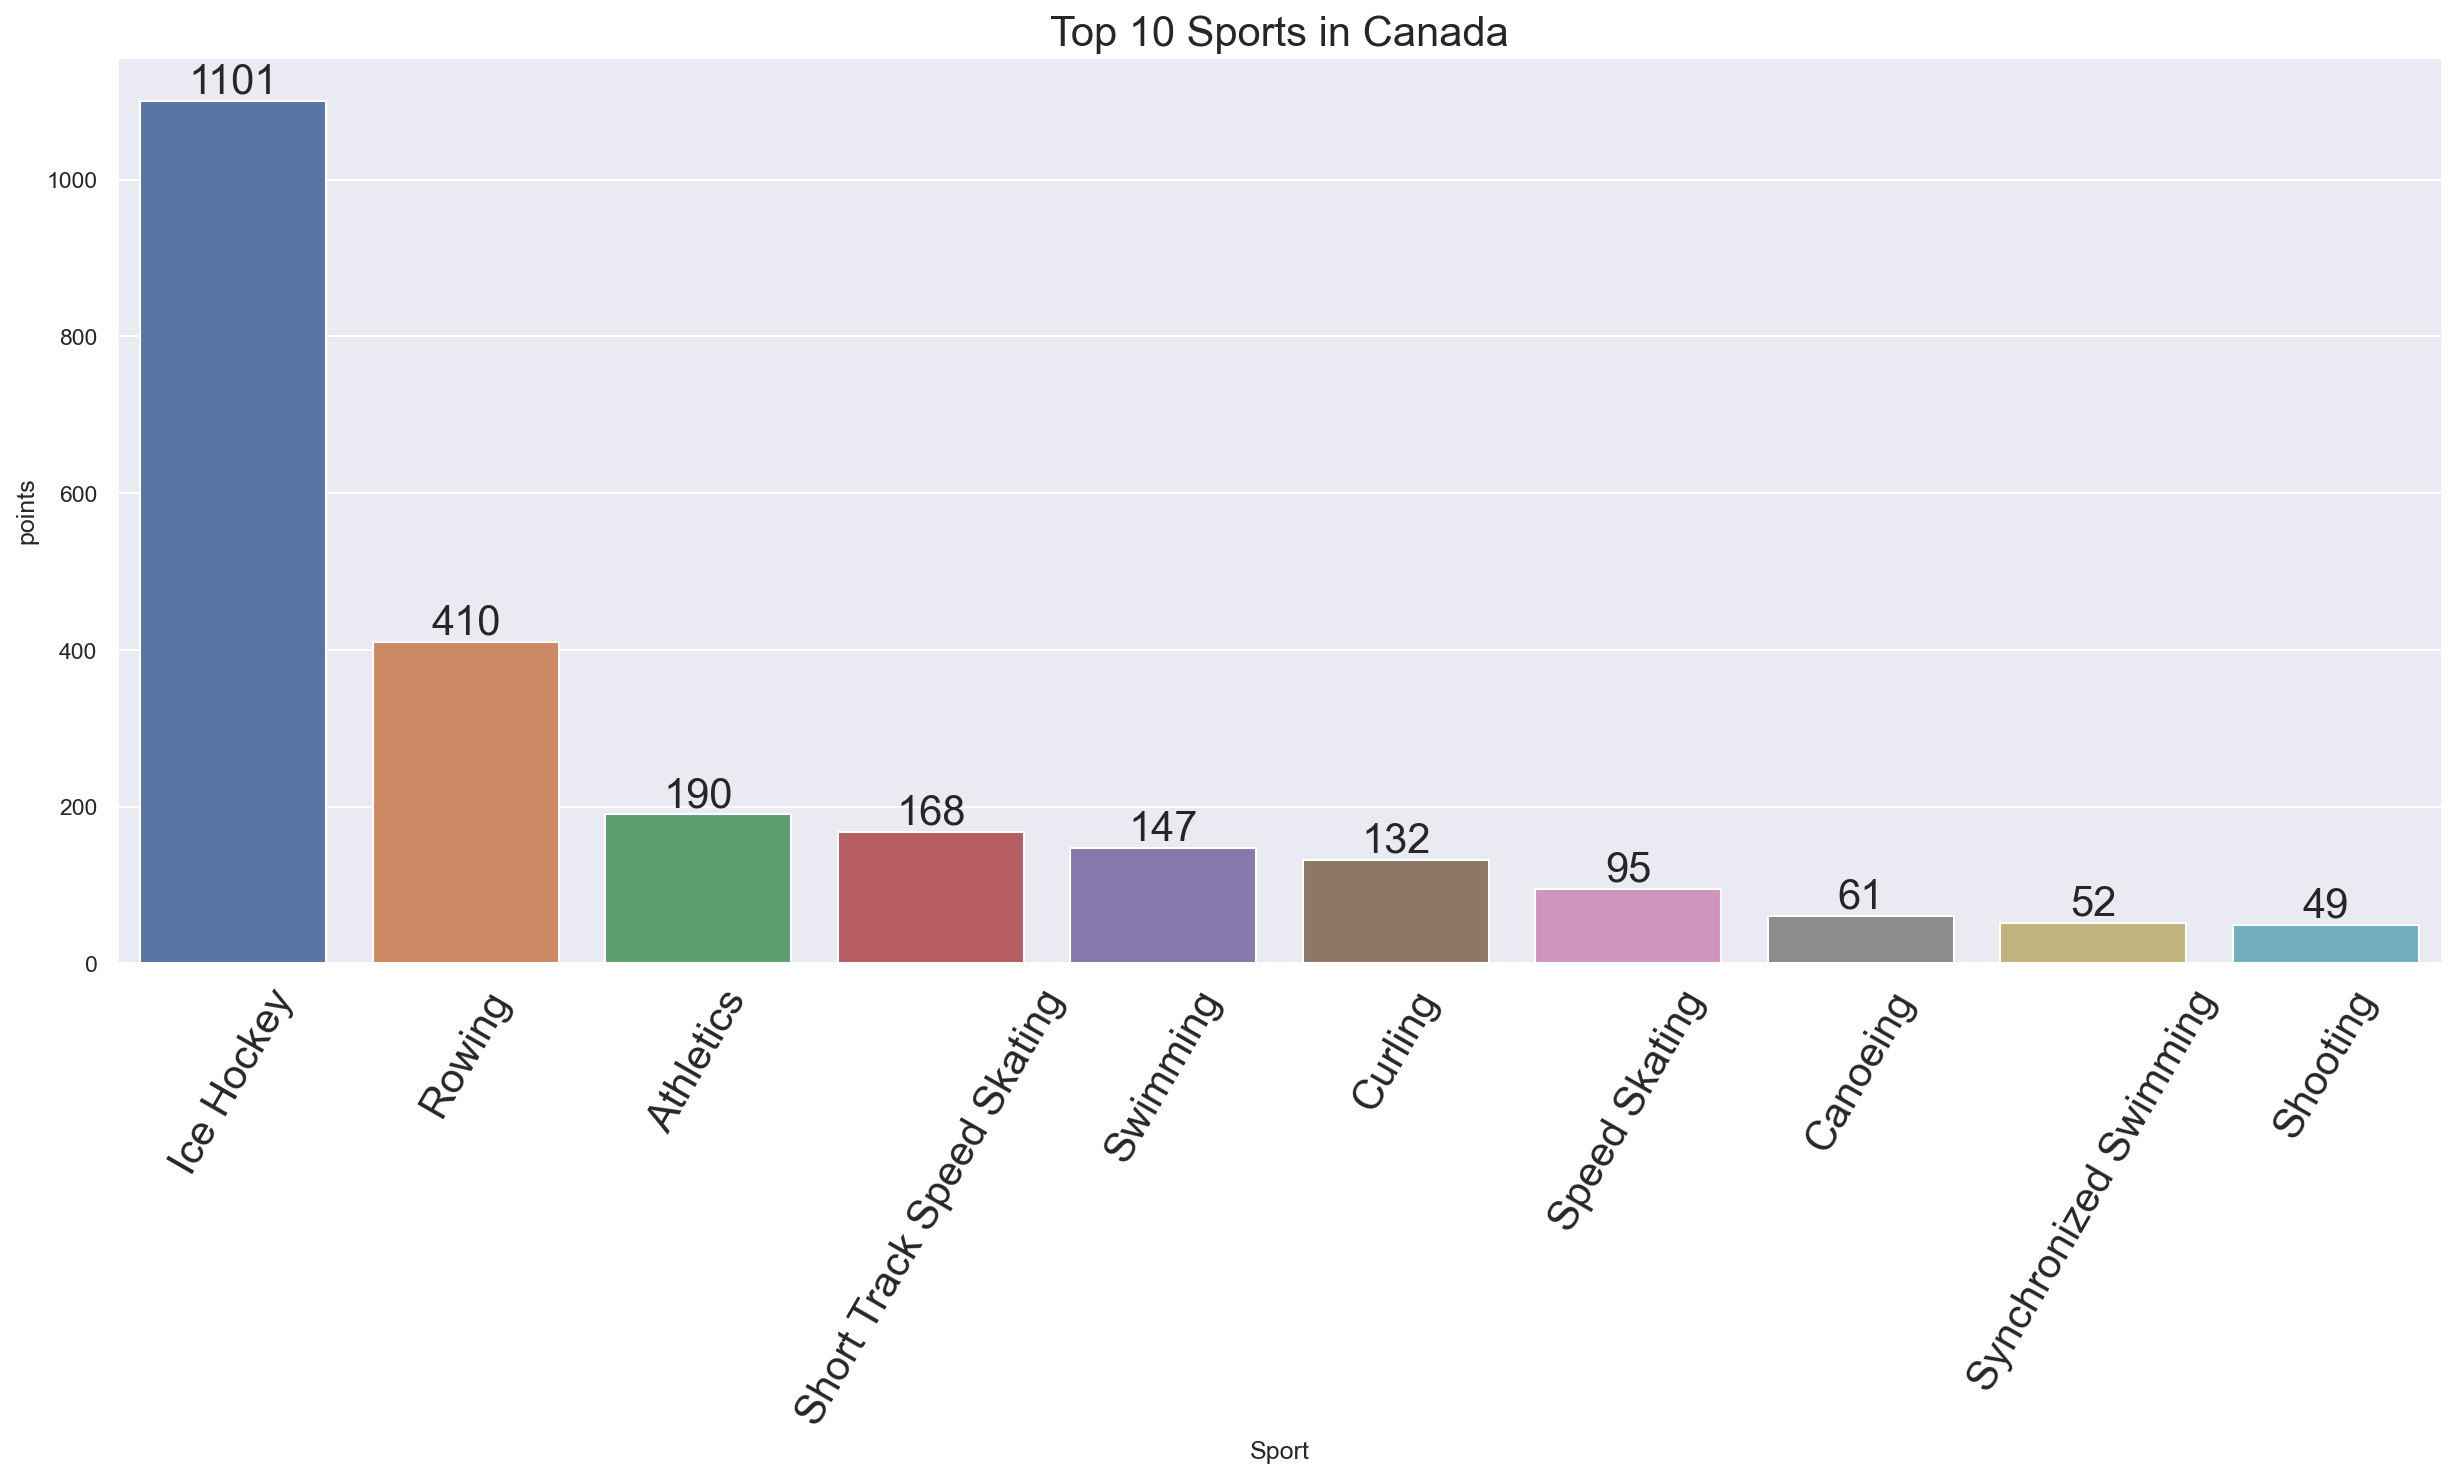

In [425]:
for country in top_ctry:
    top_sports_ctry(country)

It is familiar to most people that the top performing sports in United States are Swimming, Athletics and Basketball, the top performing sports in Russia are Athletics, Synchronized Swimming and Fencing, the top performing sports in Canada are Ice Hockey, Rowing and Atheletics.

Hypoyhesis 2 can be proven, since it can be seen that there are some similarities between top performing sports in United States, Russia and Canada: Athletics and Swimming appear in all three countries' top sports, and the winter sports such as Ice Hockey and Skiing also appear commonly in top sports. This makes sense since Athletics and Swimming are two sports that have the most competitions in Olympics and the total medals offered are also the most. 

Speaking of the distributions, United States and Canada seem to have a highlt skewed performace towards some particular sports, such as United States won 3251 and 2995 medal points in Atheletics and Swimming, but only 290 in football. A notable fact is that the medal points won by United States in Atheletics and Swimming are over 10 times than Russia, indicating a dominant performance in history. Similarly, the performace of Canada tend to skewed towards Ice Hockey and Rowing. In comparision, Russia's performance in top 10 sports tend to distribute more evenly.

These graphs also depicts the characteristics of the sports that these three countries are performing the best: United States and Canada seem to perform well in speed-racing sport such as Rowing, Athletics and Swimming, whereas Russia are more towards the battling and fighting, such as Fencing and Wrestling.



## Q3: Gender distribution of 20 common sports

Below is the segmented bar chart that shows the distribitions of participation of Male and Female athletes in 20 most common Olympic sports. The numbers above the bars are the proportions of female participants in each sport.


<font size=1.6> Note: Most common sports are the sports that are participated the most by the athletes of both gender in past 120 years.

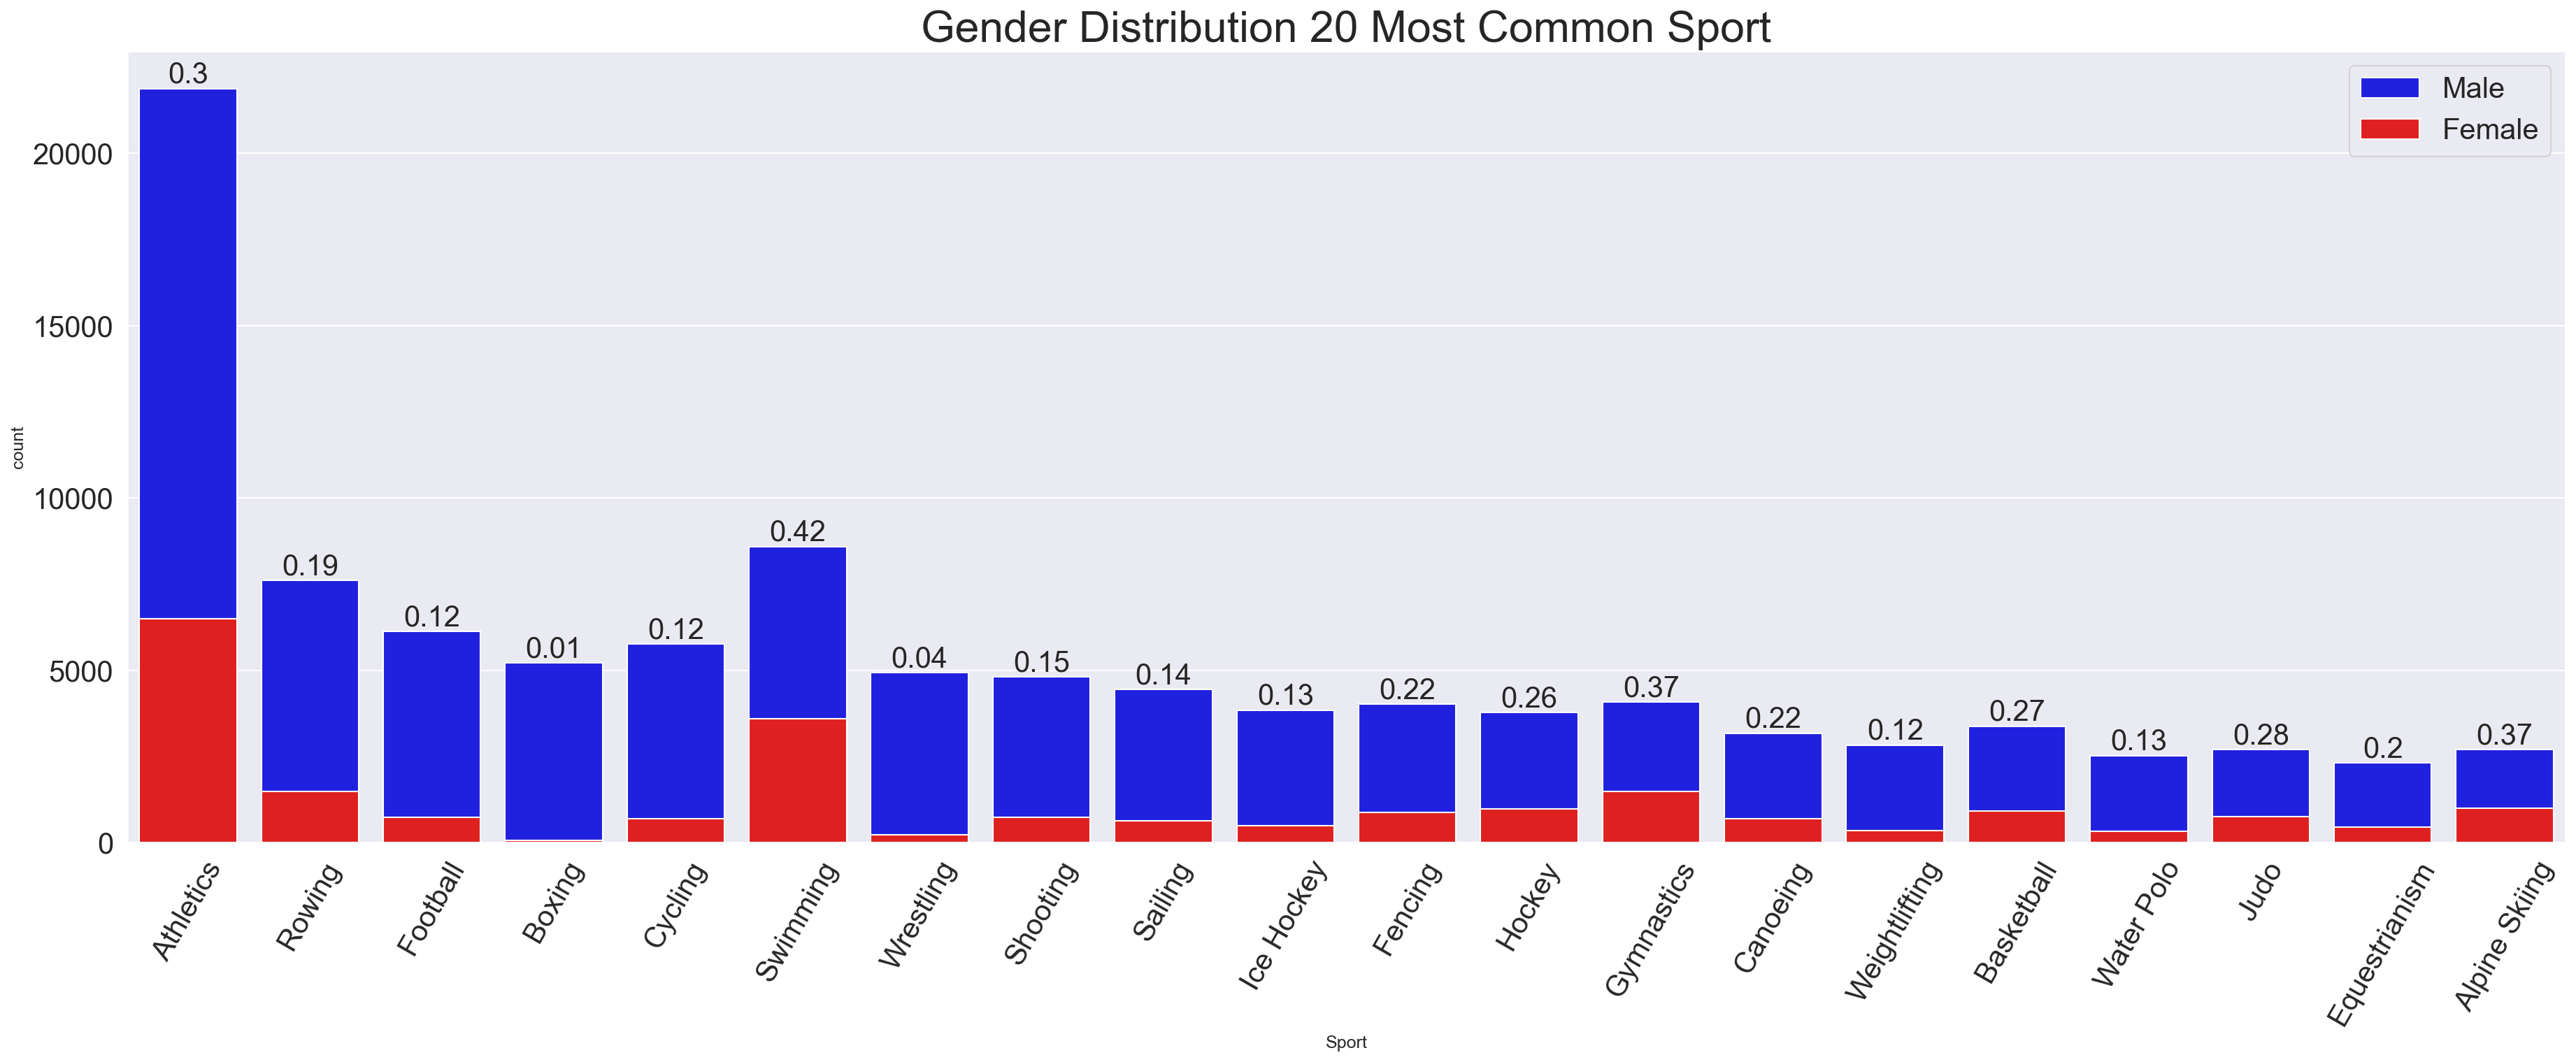

In [493]:
tot_count = athletes.groupby('Sport')['ID'].count().sort_values(ascending=False).reset_index()
tot_count.columns=['Sport','Tcount']

sportc = athletes.groupby(['Sex','Sport'])['ID'].count().sort_values(ascending=False).reset_index()
sportc1 = pd.merge(sportc,tot_count,how='inner',on='Sport')
sportc1.columns=['Sex','Sport','count','Tcount']
sportc1['proportion'] = sportc1['count']/(sportc1['Tcount'])
sport20 = sportc1[:40]
plt.figure(figsize=(30,10),dpi=150)
sns.barplot(sport20['Sport'],sport20['Tcount'],color='blue',label='Male')
sns.barplot(sport20[sport20['Sex']=='F']['Sport'],sport20[sport20['Sex']=='F']['count'],color='red',label='Female')
plt.legend(fontsize=20)
plt.xticks(rotation=60,fontsize=20)
plt.yticks(fontsize=20)
plt.title('Gender Distribution 20 Most Common Sport',fontsize=30)

flist = list(round(sport20[sport20['Sex']=='F']['proportion'],2))
for x,y in enumerate(sport20[sport20['Sex']=='F']['Tcount']):
    plt.text(x,y,flist[x],ha='center',va='bottom')
plt.show()

Taking a look at the gender distribution of 20 most commonly participated sports, male athletes take up more than 50% of participation in all sports. The sports with relatively higher (over 30%) female participation are Athletics, Swimming, Gymnastics and Alpine Skiing.

This is fairly consistent with hypothesis 3 that female tend to participate more in sports that require flexibility, whereas male tend to participate in more combative and competitive sports such as wrestling and boxing.

## Q4: The average BMI of the athletes in each sport
Below are the bar chart of the average BMI for each 66 sports in the dataset.

Text(0.5, 1.0, 'Average BMI for each sport')

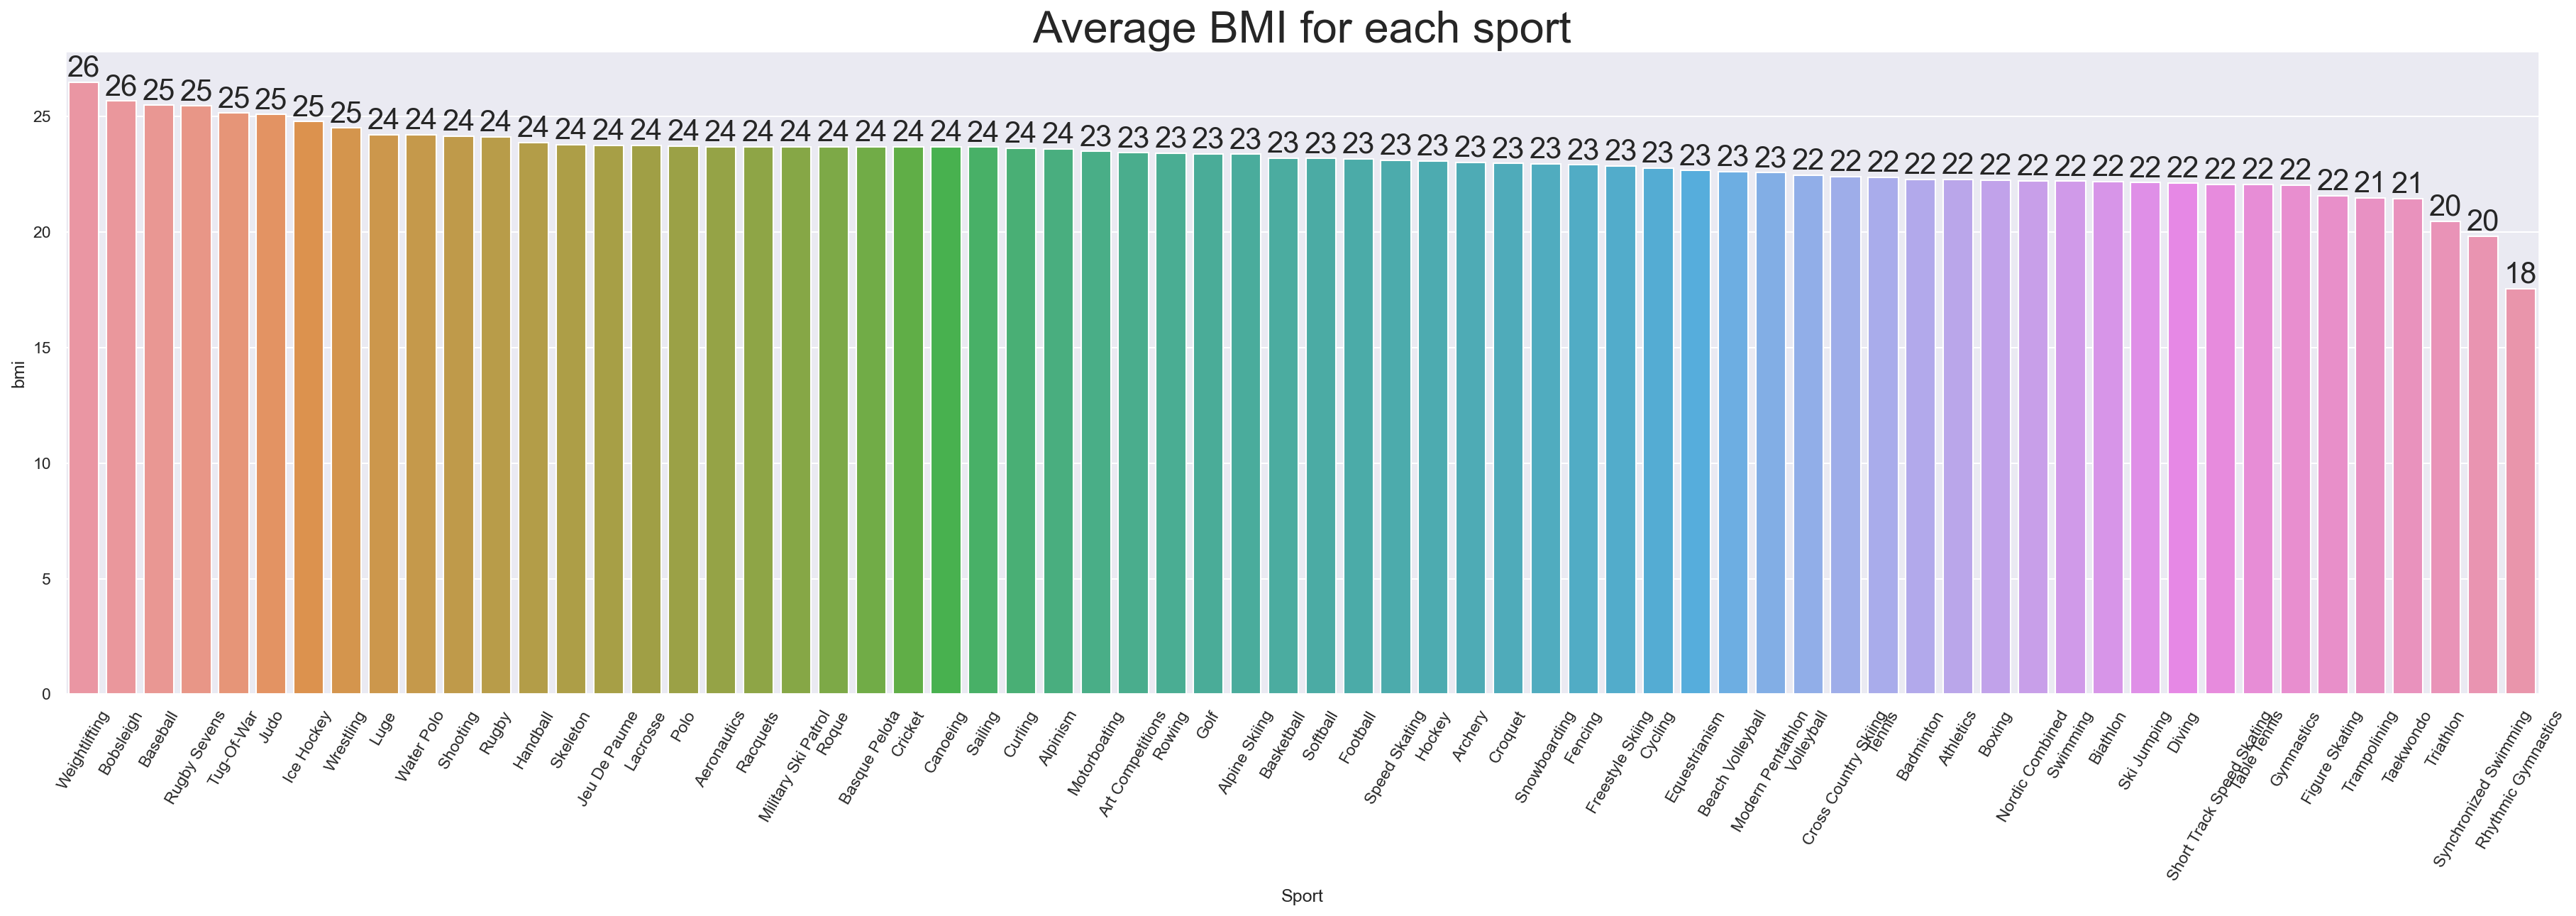

In [428]:
#bmi of different sport
athletes['bmi'] = athletes['Weight']/(athletes['Height']/100)**2
bmi = athletes.groupby('Sport')['bmi'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(30,8),dpi=150)
sns.barplot(bmi['Sport'],bmi['bmi'])
plt.xticks(rotation=60)
for x,y in enumerate(bmi['bmi']):
    plt.text(x,y,'%s' %round(y),ha='center',va='bottom')
plt.title('Average BMI for each sport',fontsize=30)

The average BMI of athletes in all 66 sports range between 18-26, which is quite a large interval. The results are consistent with hypothesis 4 that the average BMI of a sport is related to the skillset required by this sport. 

Sports that requires higher physical strength tend to have higher average BMI, it can be seen that sports with higher than 25 average BMI are those that requires stronger physical strength, such as weightlifting and Judo.


In comparison, sports that require flexibility and agility tend to have less BMI, such as Gymnastics and Swimming, which both have average BMI less than 22.

BMI between 23-24 locates in the middle range of all sports, sports in this range tend to require both physical strength and flexibility, such as Basketball and Rowing.

# Recommendations

Taking into consideartion of the trend of performance in top performing country over the past 120 years, the top performing sports of these countries, the gender distribution and the average BMI of each sport, the following recommendations are advised to SportStats:

1. WHERE to open their training clubs?
United States and Russia are fairly good choice. Although there is no increasing trend in medal points recent years, both countries perform well in wide range of sports and have well eatablished history in Olympics. However, one has to take into account the sport that they would like to participate in when considering which country to locate the training club.
2. WHAT sport should they choose?
This should be considered in conjunction with the country they would like to locate. If they prefer to locate in United States, speed-racing sports such as Athletics and Swimming are a fair choice. If they prefer to locate in Russia, combative sports are preffered, such as Wrestling and Fencing.
3. WHO should they choose? (What are the physical characterics of the athletes they should consider?)
This should be considered in conjunction with the sports they choose.
In terms of gender, sports that require more flexibility are more suitable for female, whereas sports that are more competitive and combative are more appropriate for male.
In terms of BMI, 18-20 is an ideal range for sports that requires flexibility and agility, and a BMI of >=25 is suitable for sports that requires significant physical strength. For other sports that requires more generic skills, a BMI of 22-24 is suitable.
